In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load train and test datasets
train_path = "../df_train.csv"
test_path = "../df_test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

def downsample_data(df, factor):
    """Downsample dataframe by taking every nth row"""
    return df.iloc[::factor]

# Sort and downsample
train = train.sort_values(['PeopleId', 'activityID'])
test = test.sort_values(['PeopleId', 'activityID'])
train = downsample_data(train, 5)
test = downsample_data(test, 5)

# Exclude unnecessary columns
exclude_cols = ["activityID", "PeopleId"]
train = train.drop('Unnamed: 0', axis=1, errors='ignore')
test = test.drop('Unnamed: 0', axis=1, errors='ignore')

# Identify columns to normalize
cols_to_normalize = [col for col in train.columns if col not in exclude_cols]

def normalize_per_person(df, cols_to_normalize, group_col):
    """Normalize features per person using z-score normalization"""
    normalized_df = df.copy()
    
    for group_id, group in df.groupby(group_col):
        for col in cols_to_normalize:
            values = group[col]
            mean_val = values.mean()
            std_val = values.std()
            normalized_df.loc[group.index, col] = (
                (values - mean_val) / std_val if std_val != 0 else 0.0
            )
    
    return normalized_df

train = normalize_per_person(train, cols_to_normalize, "PeopleId")
test = normalize_per_person(test, cols_to_normalize, "PeopleId")
train = train.dropna()
test = test.dropna()

def calculate_magnitude(df, x_col, y_col, z_col, new_col_name):
    """Calculate magnitude from three axis components"""
    df[new_col_name] = np.sqrt(
        df[x_col].pow(2) + 
        df[y_col].pow(2) + 
        df[z_col].pow(2)
    )

def add_magnitude_columns(df):
    """Add magnitude columns for all sensors"""
    # Acceleration magnitudes
    calculate_magnitude(
        df,
        "hand acceleration X ±16g",
        "hand acceleration Y ±16g",
        "hand acceleration Z ±16g",
        "hand_acceleration_magnitude"
    )
    calculate_magnitude(
        df,
        "chest acceleration X ±16g",
        "chest acceleration Y ±16g",
        "chest acceleration Z ±16g",
        "chest_acceleration_magnitude"
    )
    calculate_magnitude(
        df,
        "ankle acceleration X ±16g",
        "ankle acceleration Y ±16g",
        "ankle acceleration Z ±16g",
        "ankle_acceleration_magnitude"
    )
    # Add more sensor types as needed...
    
    return df

def aggregate_features(df):
    """Aggregate features using various statistical measures"""
    # Get numerical columns excluding activityID and PeopleId
    cols_to_aggregate = df.select_dtypes(include=[np.number]).columns
    cols_to_aggregate = [col for col in cols_to_aggregate 
                        if col not in ["activityID", "PeopleId"]]
    
    # Group by activityID and PeopleId and calculate statistics
    aggregated = df.groupby(["activityID", "PeopleId"])[cols_to_aggregate].agg([
        'mean', 'min', 'max', 'std'
    ]).reset_index()
    
    # Flatten column names
    aggregated.columns = [
        f"{col[0]}_{col[1]}" if col[1] else col[0] 
        for col in aggregated.columns
    ]
    
    return aggregated

def create_feature_dataset(df):
    """Create feature dataset with magnitudes and aggregations"""
    df = add_magnitude_columns(df)
    return aggregate_features(df)

# Process datasets
train = create_feature_dataset(train)
test = create_feature_dataset(test)

# Prepare labels and feature matrices
y_train = pd.DataFrame({'class': train['activityID']})
y_test = pd.DataFrame({'class': test['activityID']})

X_train = train.drop(['activityID', 'PeopleId'], axis=1).values
X_test = test.drop(['activityID', 'PeopleId'], axis=1).values

# Print first 5 rows
print(train.head())

       activityID  PeopleId  heart_rate_mean  heart_rate_min  heart_rate_max  \
0  Nordic walking         1         0.645743       -0.547662        0.952326   
1  Nordic walking         2         0.671226        0.235530        0.951201   
2  Nordic walking         4         0.649828       -0.046771        1.333341   
3  Nordic walking         5         0.592275       -0.336778        0.947741   
4  Nordic walking         6         0.156766       -0.564460        0.411410   

   heart_rate_std  hand temperature (°C)_mean  hand temperature (°C)_min  \
0        0.381380                   -0.025398                  -0.245692   
1        0.143792                   -0.881663                  -1.035708   
2        0.275105                   -1.361763                  -1.590999   
3        0.324747                    0.085469                  -0.208186   
4        0.222782                   -0.861226                  -1.094440   

   hand temperature (°C)_max  hand temperature (°C)_std  ...  

In [15]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

class ActivityClassifier:
    def __init__(self, random_state=42, val_size=0.2):
        self.random_state = random_state
        self.val_size = val_size
        self.model = None
        self.le = LabelEncoder()
        
    def fit(self, X_train, y_train):
        """
        Train the classifier with a validation split
        """
        # Encode labels
        y_train_encoded = self.le.fit_transform(y_train['class'])
        
        # Split training data to create validation set
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, 
            y_train_encoded,
            test_size=self.val_size,
            random_state=self.random_state,
            stratify=y_train_encoded
        )
        
        # Create datasets
        train_data = lgb.Dataset(X_train_split, label=y_train_split)
        val_data = lgb.Dataset(X_val_split, label=y_val_split, reference=train_data)
        
        # Define model parameters
        params = {
            'objective': 'multiclass',
            'num_class': len(self.le.classes_),
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': self.random_state
        }
        
        # Train with cross-validation
        print("Training model with cross-validation...")
        cv_results = lgb.cv(
            params,
            train_data,
            num_boost_round=1000,
            nfold=5,
            stratified=True,
            callbacks=[
                lgb.log_evaluation(period=10)
            ],
            seed=self.random_state
        )
        
        # Get best number of rounds
        metrics_key = next(key for key in cv_results.keys() if 'logloss' in key.lower())
        best_rounds = len(cv_results[metrics_key])
        print(f"Best number of rounds: {best_rounds}")
        
        # Train final model
        print("\nTraining final model...")
        self.model = lgb.train(
            params,
            train_data,
            num_boost_round=best_rounds,
            valid_sets=[train_data, val_data],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=10)
            ]
        )
        
        return self
    
    def predict(self, X):
        """Make predictions"""
        if self.model is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        y_pred_proba = self.model.predict(X)
        y_pred = self.le.inverse_transform(np.argmax(y_pred_proba, axis=1))
        return pd.Series(y_pred, name='class')
    
    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        if self.model is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        # Make predictions
        y_pred = self.predict(X_test)
        
        # Ensure y_test is a Series or has 'class' column
        if isinstance(y_test, pd.DataFrame):
            y_test = y_test['class']
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        print(f"\nAccuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        
        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred)

        return accuracy
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.le.classes_,
                   yticklabels=self.le.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [16]:
classifier = ActivityClassifier()

In [17]:
classifier.fit(X_train, y_train)

Training model with cross-validation...
[10]	cv_agg's valid multi_logloss: 2.31298 + 0.0338411


/Users/jordanabinader/Documents/Education/MIT/Courses/Fall 2024/15.072fall2024/Final Project/AAEProject/myenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[20]	cv_agg's valid multi_logloss: 1.87252 + 0.0292669
[30]	cv_agg's valid multi_logloss: 1.44805 + 0.0235225
[40]	cv_agg's valid multi_logloss: 1.04333 + 0.0284699
[50]	cv_agg's valid multi_logloss: 0.754269 + 0.0689424
[60]	cv_agg's valid multi_logloss: 0.580831 + 0.0772455
[70]	cv_agg's valid multi_logloss: 0.485727 + 0.0820434
[80]	cv_agg's valid multi_logloss: 0.388917 + 0.0825123
[90]	cv_agg's valid multi_logloss: 0.323112 + 0.0662967
[100]	cv_agg's valid multi_logloss: 0.268272 + 0.0715753
[110]	cv_agg's valid multi_logloss: 0.245042 + 0.0785741
[120]	cv_agg's valid multi_logloss: 0.22691 + 0.0806633
[130]	cv_agg's valid multi_logloss: 0.210041 + 0.0775062
[140]	cv_agg's valid multi_logloss: 0.193881 + 0.0889946
[150]	cv_agg's valid multi_logloss: 0.195657 + 0.103583
[160]	cv_agg's valid multi_logloss: 0.185617 + 0.100946
[170]	cv_agg's valid multi_logloss: 0.172841 + 0.097371
[180]	cv_agg's valid multi_logloss: 0.167604 + 0.0977183
[190]	cv_agg's valid multi_logloss: 0.164727 +


Accuracy: 0.8462

Classification Report:
                      precision    recall  f1-score   support

      Nordic walking       0.00      0.00      0.00         1
    ascending stairs       1.00      1.00      1.00         1
             cycling       1.00      1.00      1.00         1
   descending stairs       1.00      1.00      1.00         1
             ironing       1.00      1.00      1.00         1
               lying       0.00      0.00      0.00         1
        rope jumping       1.00      1.00      1.00         1
             running       1.00      1.00      1.00         1
             sitting       0.50      1.00      0.67         1
            standing       1.00      1.00      1.00         1
transient activities       1.00      1.00      1.00         1
     vacuum cleaning       1.00      1.00      1.00         1
             walking       1.00      1.00      1.00         1

            accuracy                           0.85        13
           macro avg      

/Users/jordanabinader/Documents/Education/MIT/Courses/Fall 2024/15.072fall2024/Final Project/AAEProject/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jordanabinader/Documents/Education/MIT/Courses/Fall 2024/15.072fall2024/Final Project/AAEProject/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jordanabinader/Documents/Education/MIT/Courses/Fall 2024/15.072fall2024/Final Project/AAEProject/myenv/lib/python3.13/site-packages/sklearn/metrics/_classificati

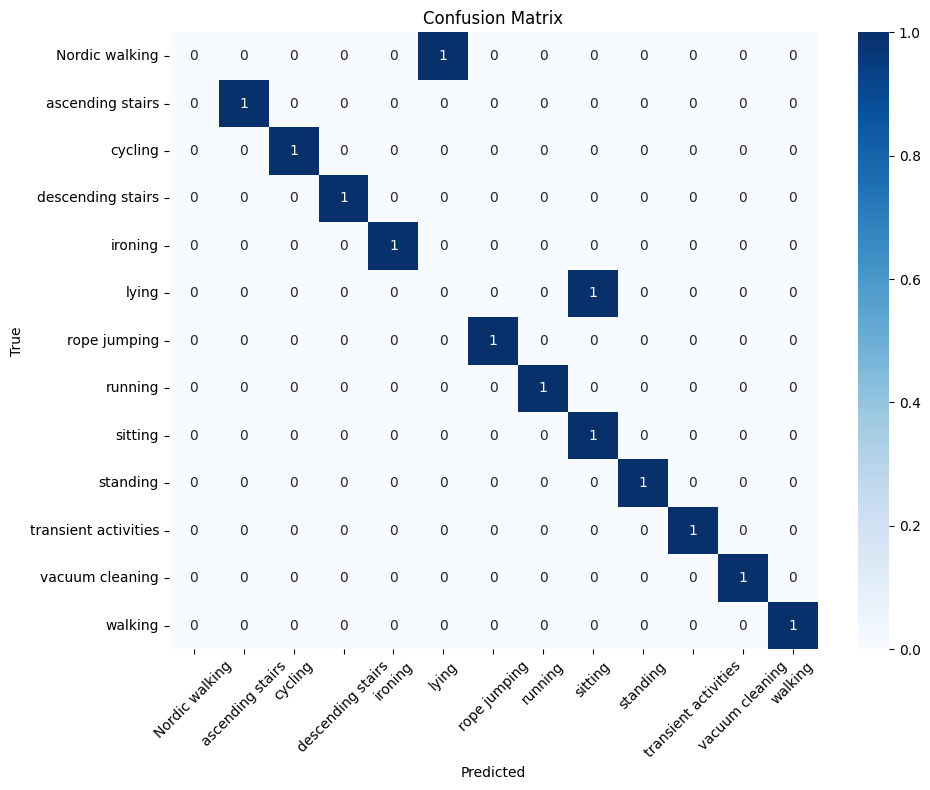

In [18]:
accuracy = classifier.evaluate(X_test, y_test)
    